In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import signal
import scipy.fftpack
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

## Load Dataset
Note: Targets[8] is neutral data

In [2]:
targets = [None] * 9

for i in range(9):
    targets[i] = pd.read_csv('recordings/target_{}_50_sec.csv'.format(i))
    targets[i]['Unnamed: 0'] = [i % 129 for i in range(len(targets[i].index))]
    targets[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)

In [3]:
# check size - make sure each target is the same length
for i in range(9):
    print('length target {} = {}'.format(i, len(targets[i].index)))
print(targets[0].columns)

length target 0 = 6400
length target 1 = 6400
length target 2 = 6400
length target 3 = 6400
length target 4 = 6400
length target 5 = 6400
length target 6 = 6400
length target 7 = 6400
length target 8 = 6400
Index(['Counter', 'P7', 'O1', 'O2', 'P8', 'TIME'], dtype='object')


##  Filtering, Averaging, and Plotting Functions

In [4]:
channels = ['P7', 'O1', 'O2', 'P8']
my_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan', 'tab:gray']
my_labels = ['Target 0', 'Target 1', 'Target 2', 'Target 3', 'Target 4', 'Target 5', 'Target 6', 'Target 7', 'Neutral Target']
# these functions filter each target - only call once
def pca_filter(variance=0.2):
    for i in range(9):
        pca = PCA(variance).fit(targets[i][channels])
        components = pca.transform(targets[i][channels])
        targets[i][channels] = pd.DataFrame(pca.inverse_transform(components))
        
def fir_filter(num_taps=400, offset_mode='average'):
    for i in range(9):
        # band pass filter - originally [0.01, 0.06]
        filt = signal.firwin(num_taps, [8.0, 15.0], pass_zero=False, fs=128.0)
        for channel in channels:
            if offset_mode == 'average':
                offset = np.average(np.array(targets[i][channel]))
            elif offset_mode == 'minimum':
                offset = np.amin(np.array(targets[i][channel]))
            elif offset_mode == 'same':
                offset = 3800
            elif offset_mode == 'zero':
                offset = 0
            else:
                raise ValueError('choose a valid offset_mode')
            targets[i][channel] = [j - offset for j in targets[i][channel]]
            targets[i][channel] = signal.convolve(targets[i][channel], filt, mode='same')
            
def alt_fir_filter():
    # source: https://scipy-cookbook.readthedocs.io/items/FIRFilter.html
    sample_rate = 128.0
    nsamples = len(targets[0].index)
    nyq_rate = sample_rate / 2.0
    width = 5.0 / nyq_rate
    ripple_db = 60.0
    N, beta = signal.kaiserord(ripple_db, width)
    cutoff_hz = 8.0
    taps = signal.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
    for i in range(9):
        for channel in channels:
            targets[i][channel] = signal.lfilter(taps, 1.0, np.array(targets[i][channel]))
        
def plot_time_all():
    # df plot
    for i in range(9):
        fig, ax = plt.subplots(figsize=(10, 5))
        for channel in channels:
            targets[i][channel].plot(y=channel, title='Target {} Signal Over Time'.format(i) if i != 8 else 'Neutral Target Signal')
        ax.legend(channels)
        
        
def plot_channel(target, channel):
    fig, ax = plt.subplots(figsize=(10, 5))
    target[channel].plot(y=channel, title='{} Signal Over Time'.format(channel))
    
def plot_fft_all(xlim=0.025):
    N = len(targets[0].index)
    T = 1.0 / 128.0
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    for i in range(9):
        fig, ax = plt.subplots(figsize=(10, 5))
        for channel in channels:
            yf = scipy.fftpack.fft(np.array(targets[i][channel])).real
            ax.plot(xf, 2.0 / N * np.abs(yf[:N//2]))
            ax.set_xlim([0, xlim])
        ax.legend(channels)
        
def cut_ends(cutoff=200):
    # this function is used after FIR filtering because the ends have extremely high peaks
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)] + [i for i in range(n-1, n-cutoff-1, -1)]
    for i in range(9):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)
        
        
def plot_averages():
    # plot all targets all channels on one plot. possibly messy
    fig, ax = plt.subplots(figsize=(15, 7))
    for i, avg_sig in enumerate(averages_all_targets):
        for channel in channels:
            avg_sig.plot(x='Counter', y=channel, ax=ax, color=my_colors[i], label=my_labels[i] if channel=='P7' else "")
    ax.legend()
    ax.set_title('Average Signals for All Targets and All Channels')
    
def plot_target_average(ind):
    # all channels for one target - input is index of targets
    fig, ax = plt.subplots(figsize=(15, 7))
    for j, channel in enumerate(channels):
        averages_all_targets[ind].plot(x='Counter', y=channel, ax=ax, color=my_colors[j], label=channel)
    ax.set_title('Target {} Average Signal for All Channels'.format(ind) if ind != 8 else 'Neutral Target Average Signal for All Channels')
        
def plot_averages_by_channel():
    # 4 plots, each with 8 targets + neutral
    for channel in channels:
        fig, ax = plt.subplots(figsize=(15, 7))
        for i, avg_sig in enumerate(averages_all_targets):
            avg_sig.plot(x='Counter', y=channel, ax=ax, color=my_colors[i], label=my_labels[i])
        ax.legend(loc='upper right')
        ax.set_title('Channel {} Average Signals for All Targets'.format(channel))
        
    
def averaging():
    averages = []
    for target in targets:
        average_for_target = []
        o1_count = [[] for i in range(129)]
        o2_count = [[] for i in range(129)]
        p7_count = [[] for i in range(129)]
        p8_count = [[] for i in range(129)]
        for i in range(len(target.index)):
            count_val = target['Counter'][i]
            o1_count[count_val].append(target['O1'][i])
            o2_count[count_val].append(target['O2'][i])
            p7_count[count_val].append(target['P7'][i])
            p8_count[count_val].append(target['P8'][i])
        for i in range(129):
            # find average for each count_val
            o1avg = np.average(np.array(o1_count[i]))
            o2avg = np.average(np.array(o2_count[i]))
            p7avg = np.average(np.array(p7_count[i]))
            p8avg = np.average(np.array(p8_count[i]))
            row = {'Counter' : i, 'O1' : o1avg, 'O2' : o2avg, 'P7' : p7avg, 'P8' : p8avg}
            average_for_target.append(row)
            
        averages.append(pd.DataFrame(data=average_for_target))
        
    return averages
    

In [5]:
# plot_time_all()
# plot_fft_all()

## Apply Filtering

In [6]:
# including comments for copy-pastable function calls

# pca_filter(variance=0.5)
fir_filter(num_taps=400, offset_mode='zero')
# alt_fir_filter()


# plot_time_all()
# cut_ends()
# plot_channel(targets[0], 'O1')
# plot_fft_all(xlim=7)

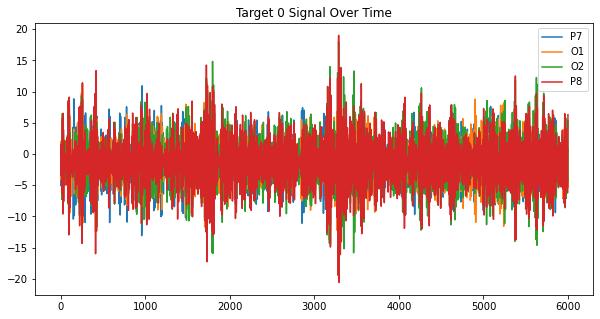

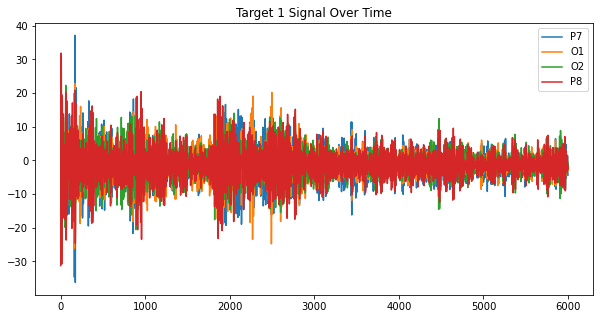

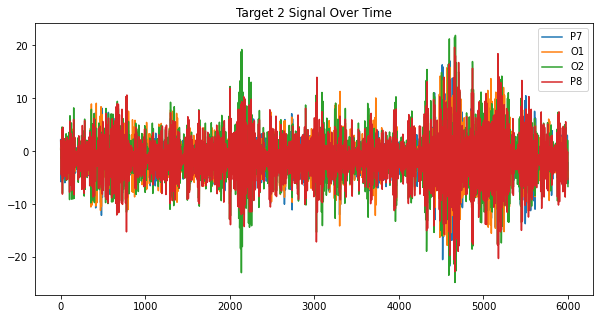

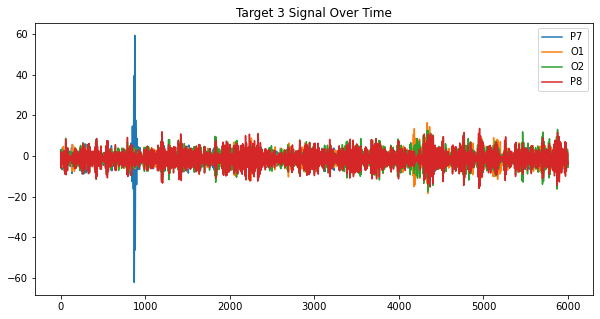

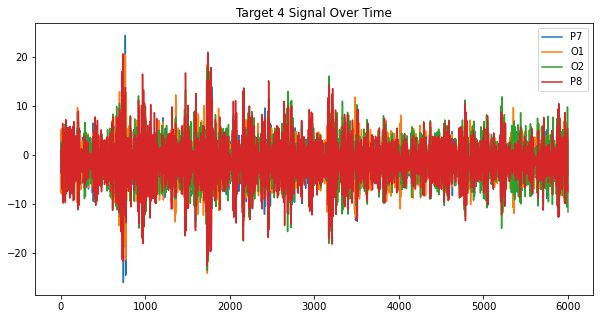

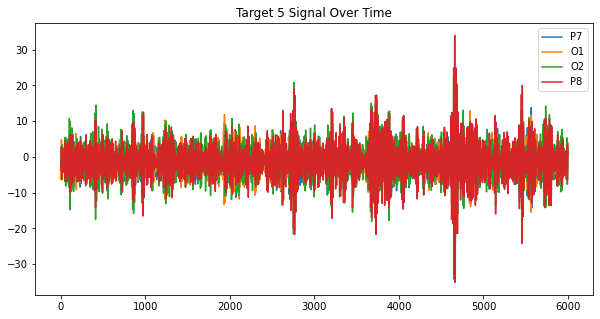

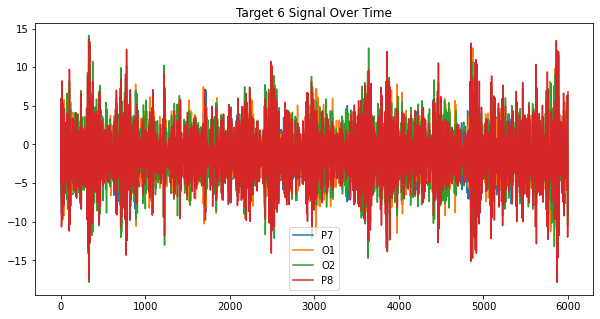

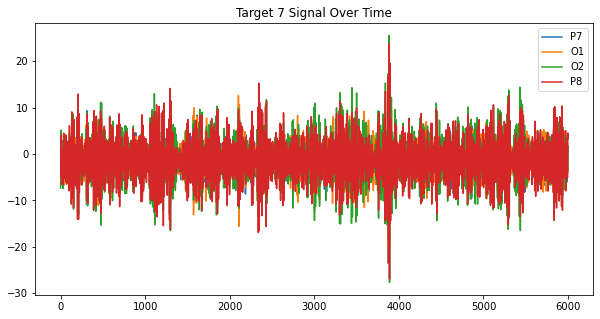

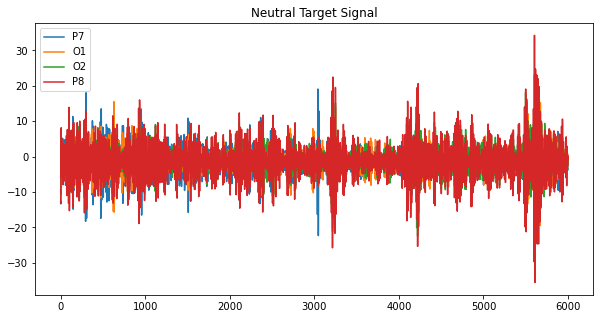

In [7]:
cut_ends()
plot_time_all()

## Apply Averaging on Counter Value

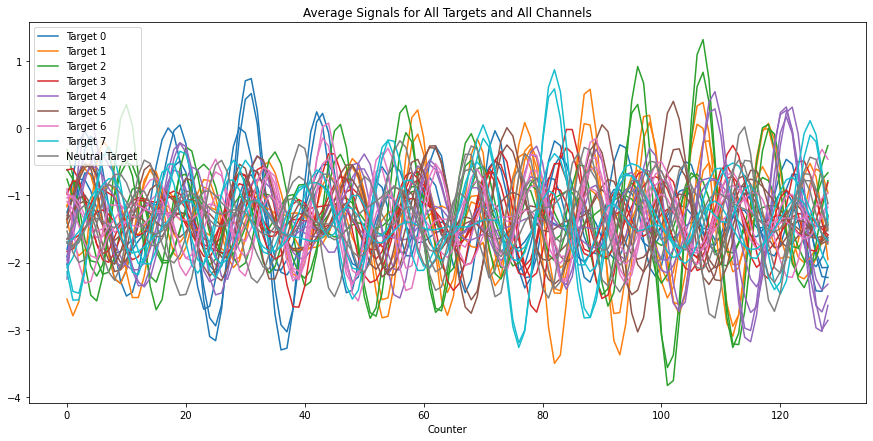

In [8]:
# perform averaging for targets
averages_all_targets = averaging()
plot_averages()

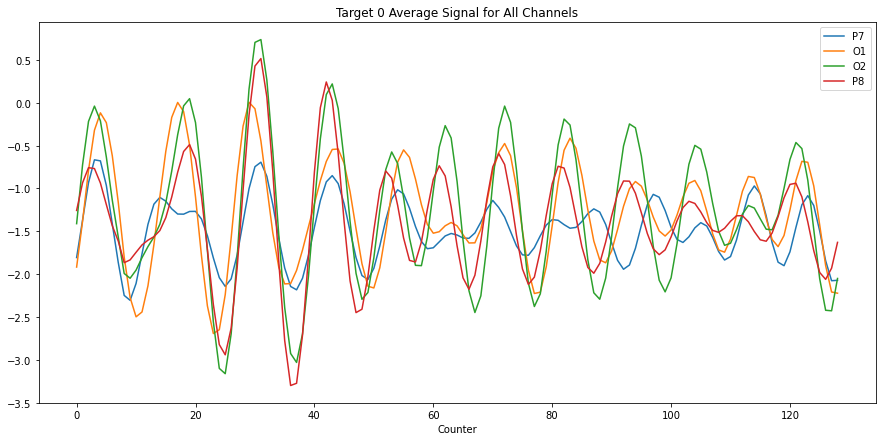

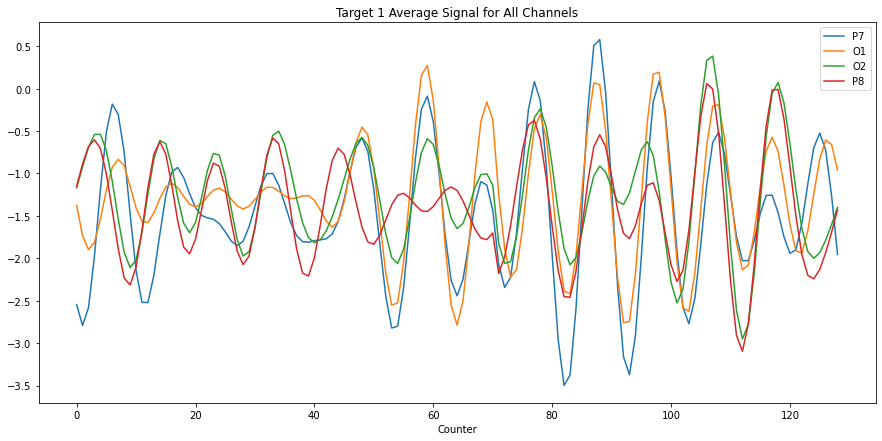

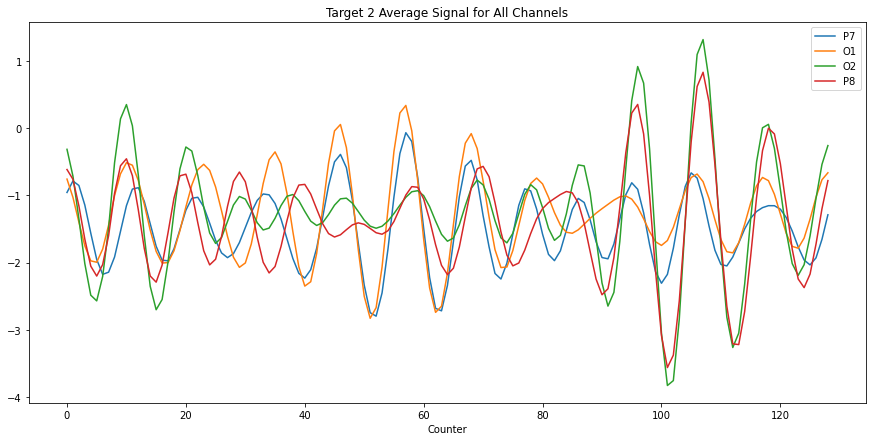

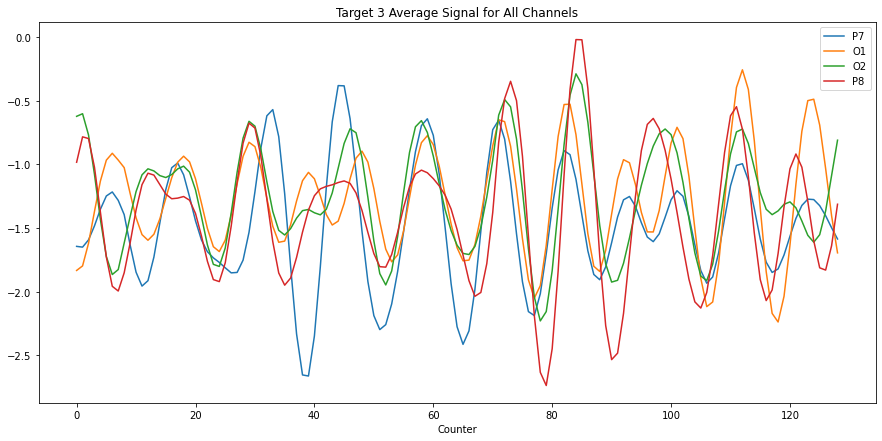

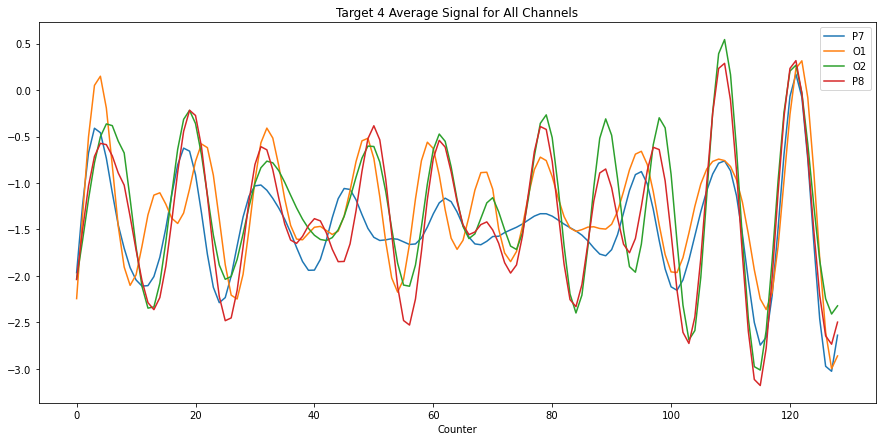

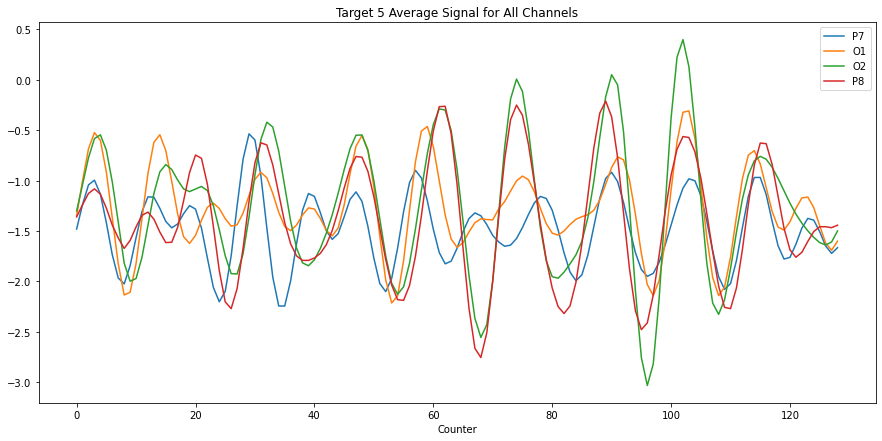

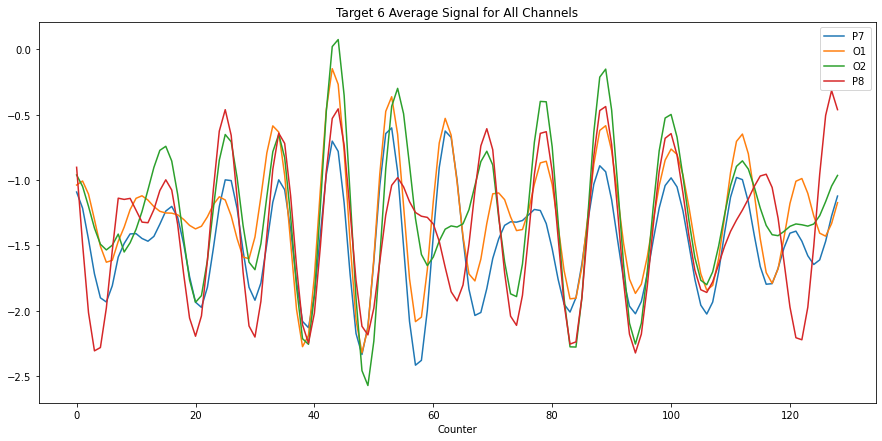

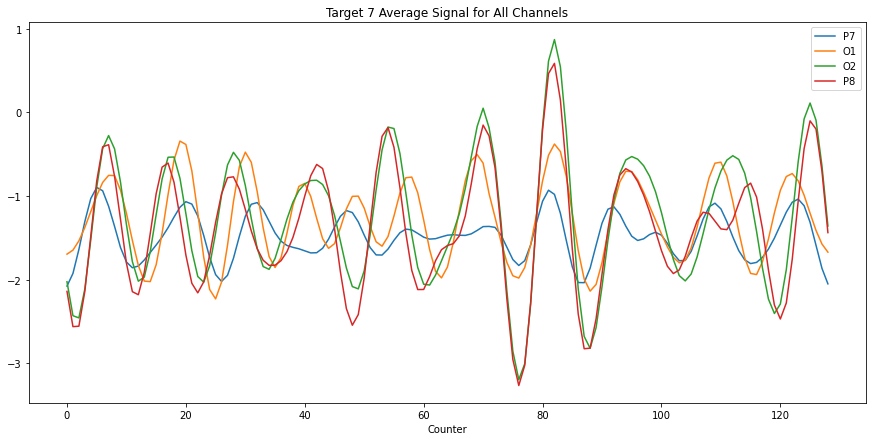

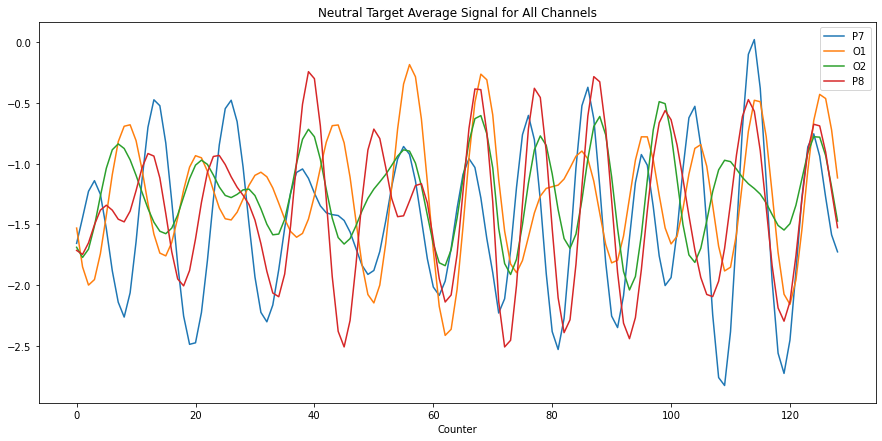

In [9]:
for i in range(9):
    plot_target_average(i)

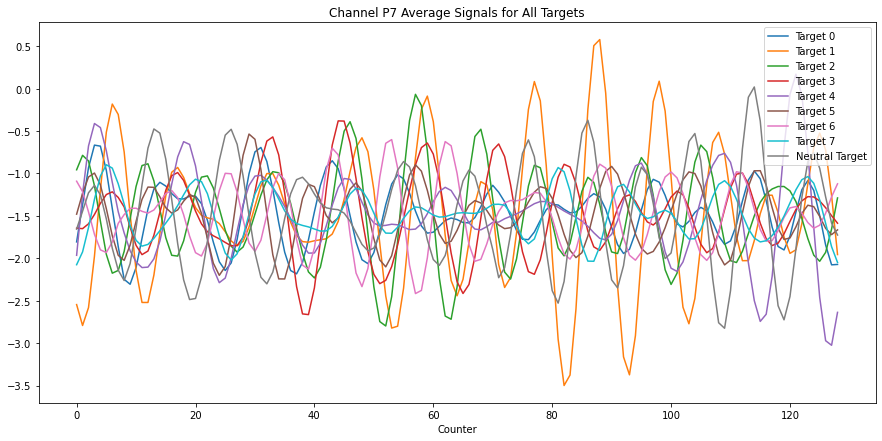

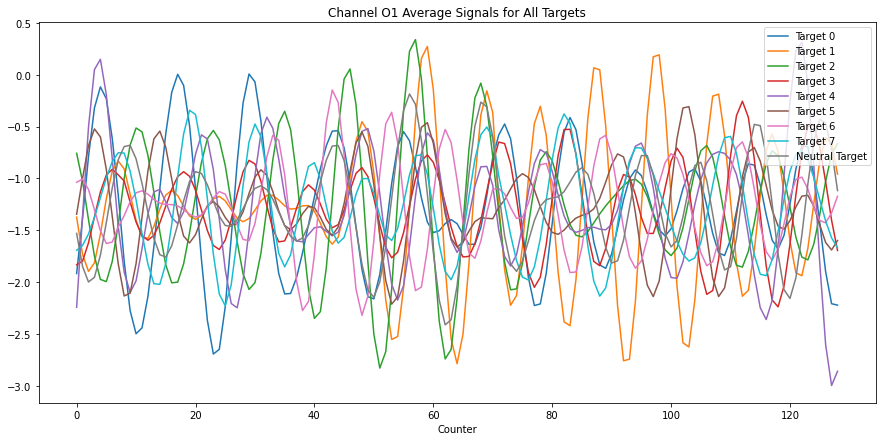

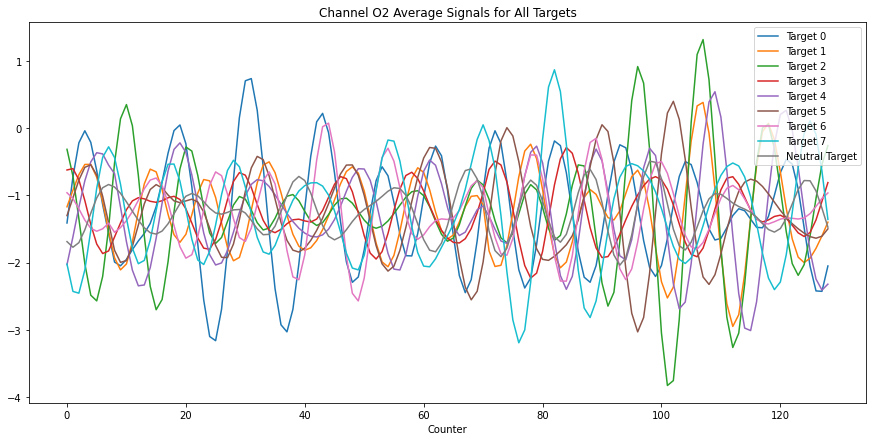

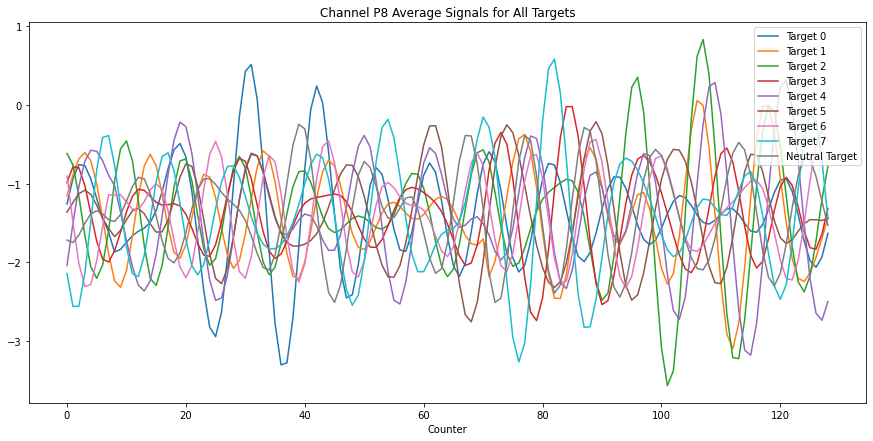

In [10]:
plot_averages_by_channel()